In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_metadata_networks_tntp,
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import SDModel, BeckmannModel, TwostageModel
from src.algs import subgd, ustm, frank_wolfe, cyclic, N_conjugate_frank_wolfe 
from src.cvxpy_solvers import get_max_traffic_mat_mul
from src.commons import Correspondences

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

In [3]:
networks_path = Path("./TransportationNetworks")

folder = "SiouxFalls"
net_name = "SiouxFalls_net"
traffic_mat_name = "SiouxFalls_trips"

# folder = "Anaheim"
# net_name = "Anaheim_net"
# traffic_mat_name = "Anaheim_trips"
    
# folder = "Barcelona"
# net_name = "Barcelona_net"
# traffic_mat_name = "Barcelona_trips"

    
net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=True
graph.number_of_edges()=76, graph.number_of_nodes()=24


In [4]:
beckmann_model = BeckmannModel(graph, correspondences)

eps = 1e-4
mean_bw = beckmann_model.graph.ep.capacities.a.mean()
mean_cost = beckmann_model.graph.ep.free_flow_times.a.mean()

# cost suboptimality <= eps * (average link cost * avg bandwidth * |E| \approx total cost when beta=1)
eps_abs = eps * mean_cost * mean_bw * graph.number_of_edges()

eps_cons_abs = eps * mean_bw 
# sum of capacity violation <= eps * average link capacity
print(eps_abs, eps_cons_abs)

321.76227778320316 1.0247206298828127


# Beckmann

In [5]:
times_e_ustm, flows_e_ustm, logs, optimal = ustm(beckmann_model, eps_abs, max_iter=2000, stop_by_crit=False)
dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "shortest paths calls")


100%|██████████| 2000/2000 [00:23<00:00, 86.75it/s]

7946 shortest paths calls


In [6]:
times_e_fw, flows_e_fw, logs, optimal = frank_wolfe(beckmann_model, eps_abs,  max_iter=7700, stop_by_crit=False)
dgap_fw, time_log_fw , primal_r_gap_fw = logs

100%|██████████| 7700/7700 [00:21<00:00, 364.64it/s]


In [7]:
times_e_nfw, flows_e_nfw, logs, optimal = N_conjugate_frank_wolfe(beckmann_model, eps_abs,  max_iter=4000, stop_by_crit=False, cnt_conjugates=3 , linesearch=True)
dgap_nfw, time_log_nfw , primal_r_gap_nfw = logs

100%|██████████| 3999/3999 [00:22<00:00, 181.24it/s]


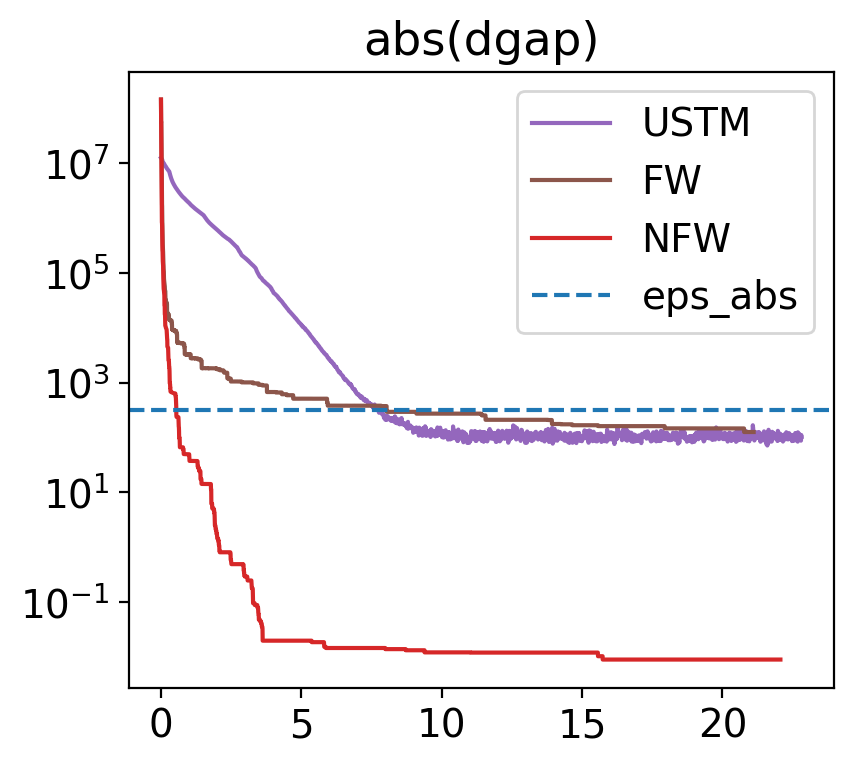

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_ustm = np.abs(dgap_ustm)
dgap_fw = np.abs(dgap_fw)
dgap_nfw = np.abs(dgap_nfw)
plt.plot(time_log_ustm, dgap_ustm, c="C4", label="USTM")
plt.plot(time_log_fw, dgap_fw, c="C5", label="FW")
plt.plot(time_log_nfw, dgap_nfw, c="C3", label="NFW")
plt.axhline(y=np.ones(max(dgap_ustm.size, dgap_fw.size))[0] * eps_abs, linestyle= '--', label='eps_abs')
plt.yscale("log")
plt.title("abs(dgap)")
plt.legend()


# SD

In [9]:
# %%time

# for Anaheim 18 min on my laptop (for np.ones matrix ~3 min, omg. maybe scaling impacts?). result \approx 0.529
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.traffic_mat, solver=cp.SCS)
sd_max_traffic_mul = 0.529

# for SiouxFalls
# sd_max_traffic_mul = get_max_traffic_mat_mul(graph, correspondences.node_traffic_mat, solver=cp.ECOS, 
#                                              max_iters=1000, verbose=False)

print(f"{sd_max_traffic_mul=},")

corrs = Correspondences(traffic_mat=correspondences.traffic_mat * sd_max_traffic_mul * 0.9,
                        node_traffic_mat=correspondences.node_traffic_mat * sd_max_traffic_mul * 0.9,
                        sources=correspondences.sources,
                        targets=correspondences.targets)

sd_model = SDModel(graph, corrs)
# model = SDModel(graph, traffic_mat * sd_max_traffic_mul * 1.1)  # you should see that constraints error does not converge

sd_max_traffic_mul=0.529,


## cvxpy edge-based

## Ustm

In [10]:
%%time

times_e_ustm, flows_e_ustm, logs, optimal = ustm(sd_model, eps_abs, eps_cons_abs,
                                                                         max_iter=1000, stop_by_crit=True)

dgap_ustm, cons_log_ustm, time_log_ustm = logs
print(len(dgap_ustm), "iters")


100%|██████████| 1000/1000 [00:10<00:00, 93.85it/s]

4008 iters
CPU times: user 10.8 s, sys: 384 ms, total: 11.2 s
Wall time: 10.7 s


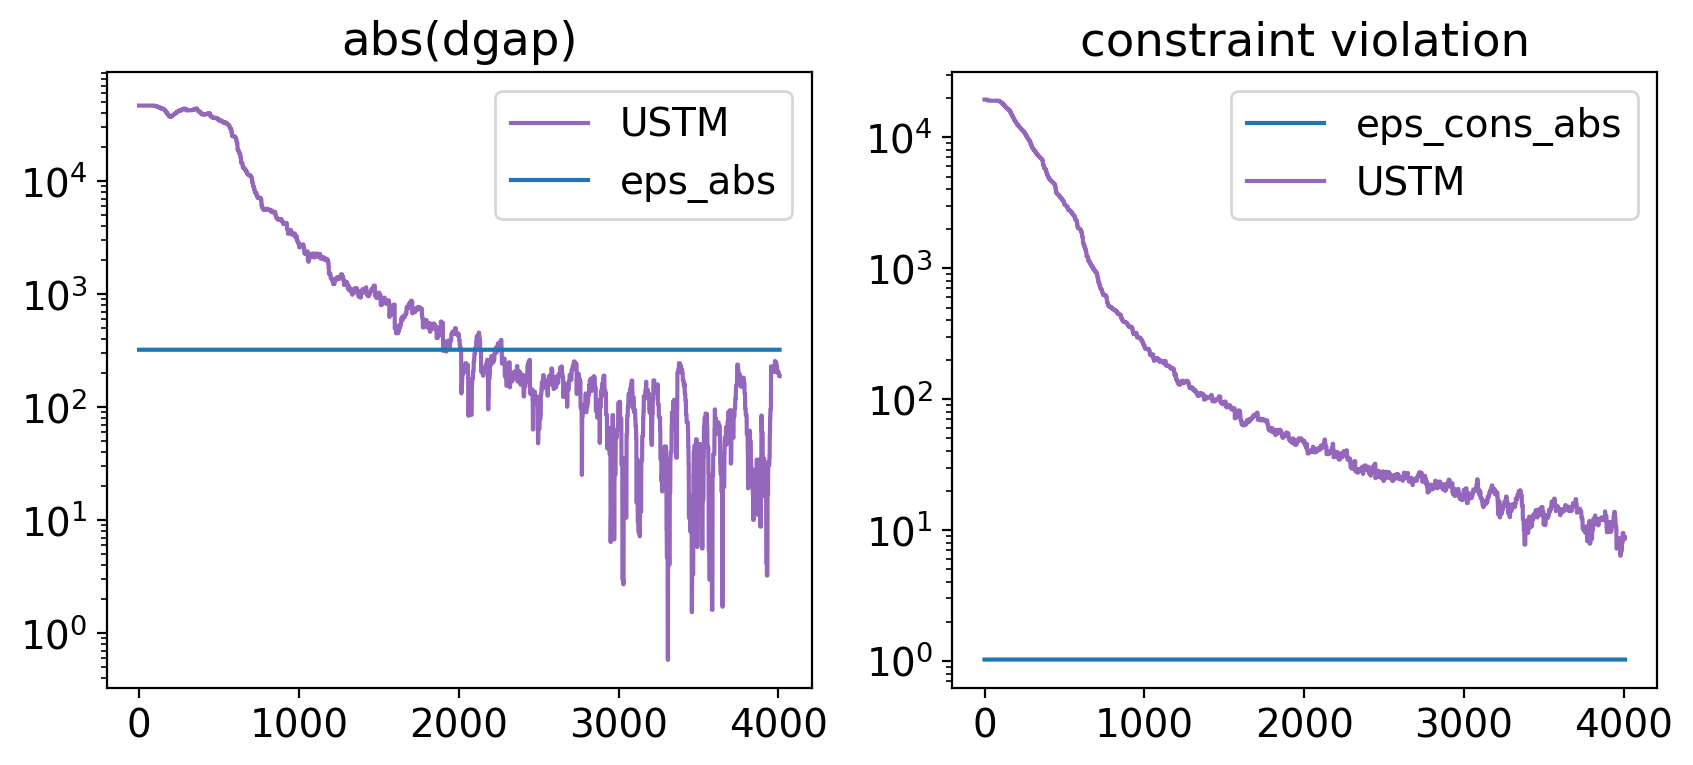

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_ustm)
plt.plot(dgap_abs, c="C4", label="USTM")
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.yscale("log")
plt.ylim(None, dgap_abs.max() * 2)
plt.title("abs(dgap)")
plt.legend()

plt.subplot(122)
plt.plot(np.ones(len(cons_log_ustm)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_ustm, c="C4", label="USTM")
plt.title("constraint violation")
plt.yscale("log")
plt.legend()

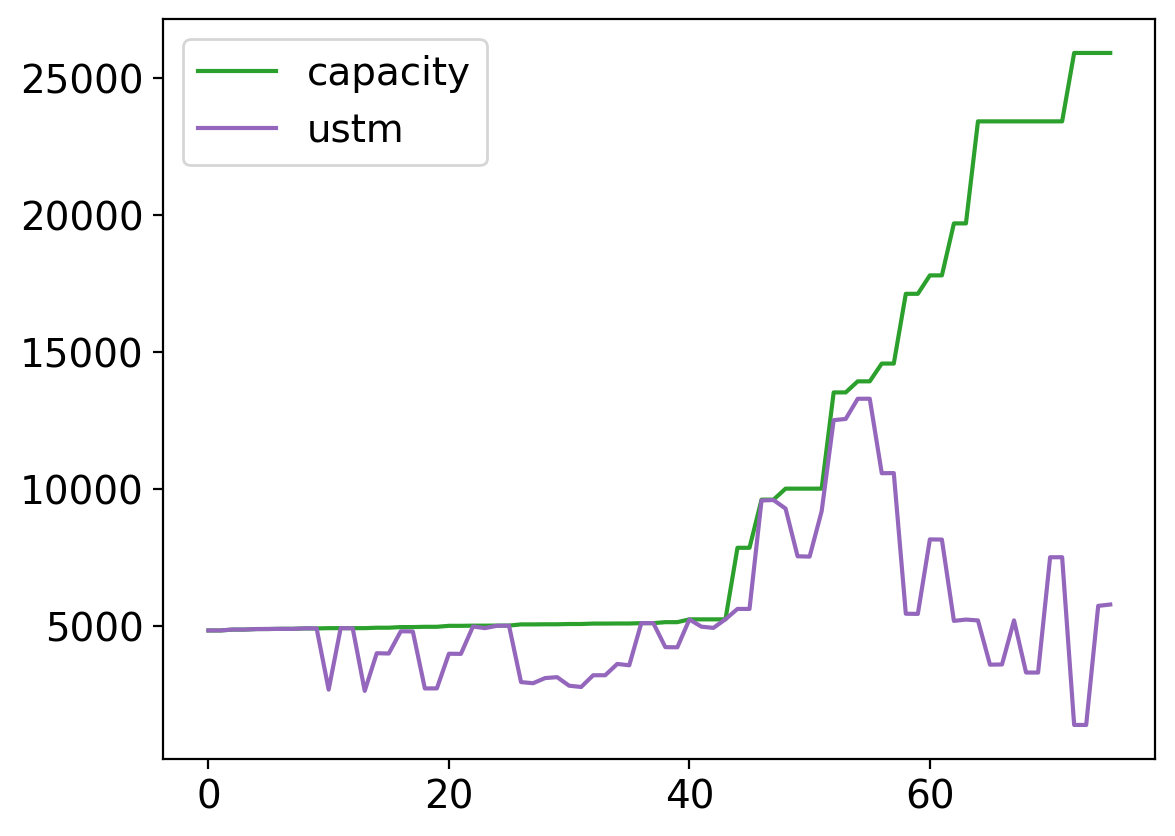

In [12]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_ustm[order], label="ustm", c="C4")

plt.legend()

# Subgd

In [13]:
%%time

times_e_subgd, flows_e_subgd, logs, optimal = subgd(sd_model, R=10, eps_abs=eps_abs, 
                                                                   eps_cons_abs=eps_cons_abs, max_iter=1000)

dgap_subgd, cons_log_subgd = logs

100%|██████████| 1000/1000 [00:02<00:00, 378.54it/s]

CPU times: user 2.64 s, sys: 66.9 ms, total: 2.71 s
Wall time: 2.64 s


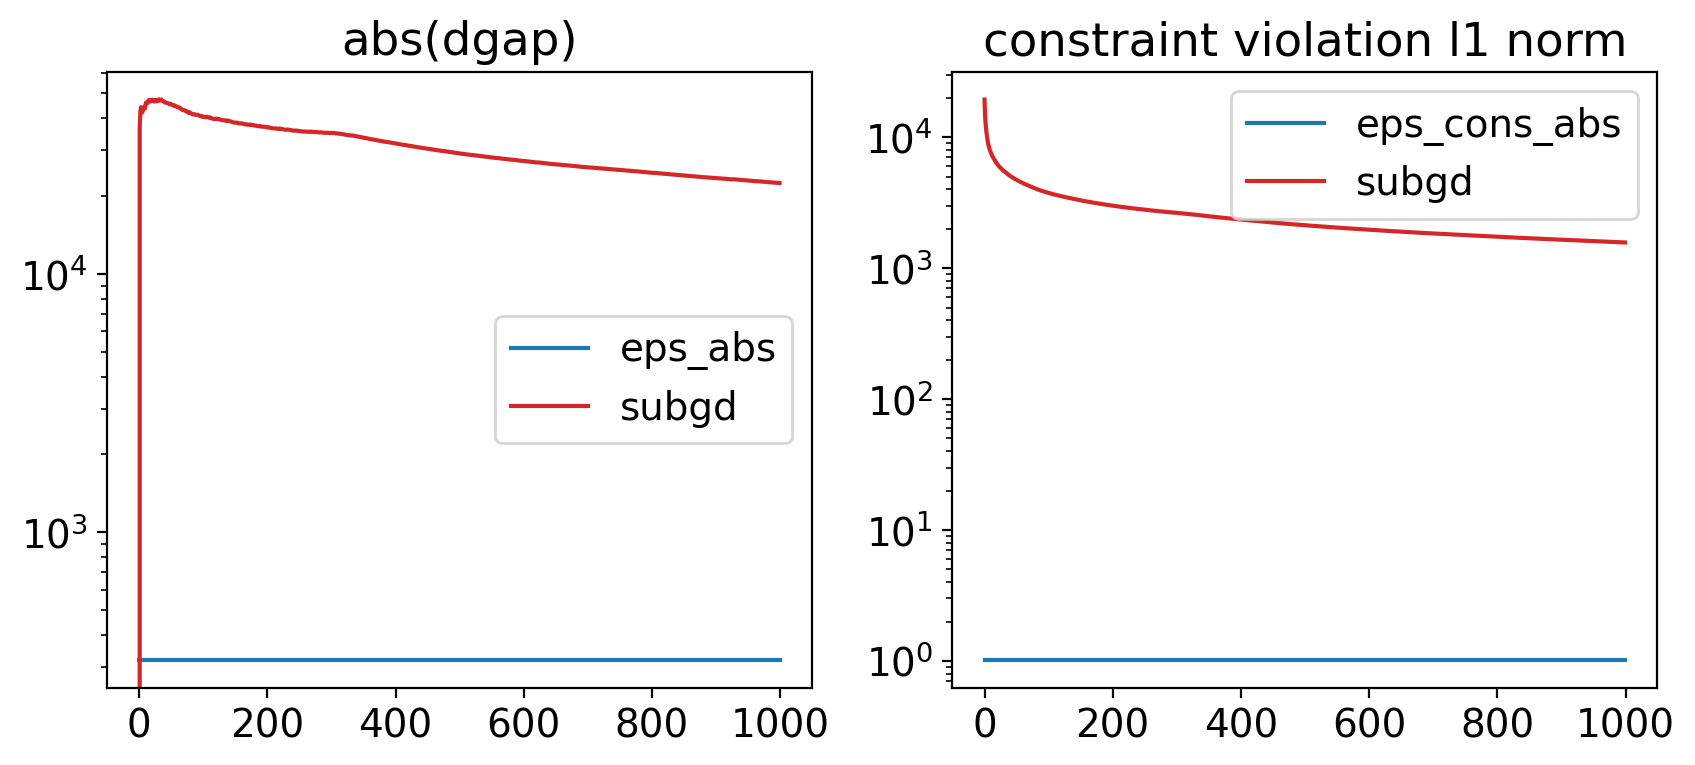

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
dgap_abs = np.abs(dgap_subgd)
plt.plot(np.ones(dgap_abs.size) * eps_abs, label="eps_abs")
plt.plot(dgap_abs, c="C3", label="subgd")
plt.legend()
plt.yscale("log")

plt.title("abs(dgap)")
plt.subplot(122)
plt.plot(np.ones(len(cons_log_subgd)) * eps_cons_abs, label="eps_cons_abs")
plt.plot(cons_log_subgd, c="C3", label="subgd")
plt.legend()
plt.title("constraint violation l1 norm")
plt.yscale("log")


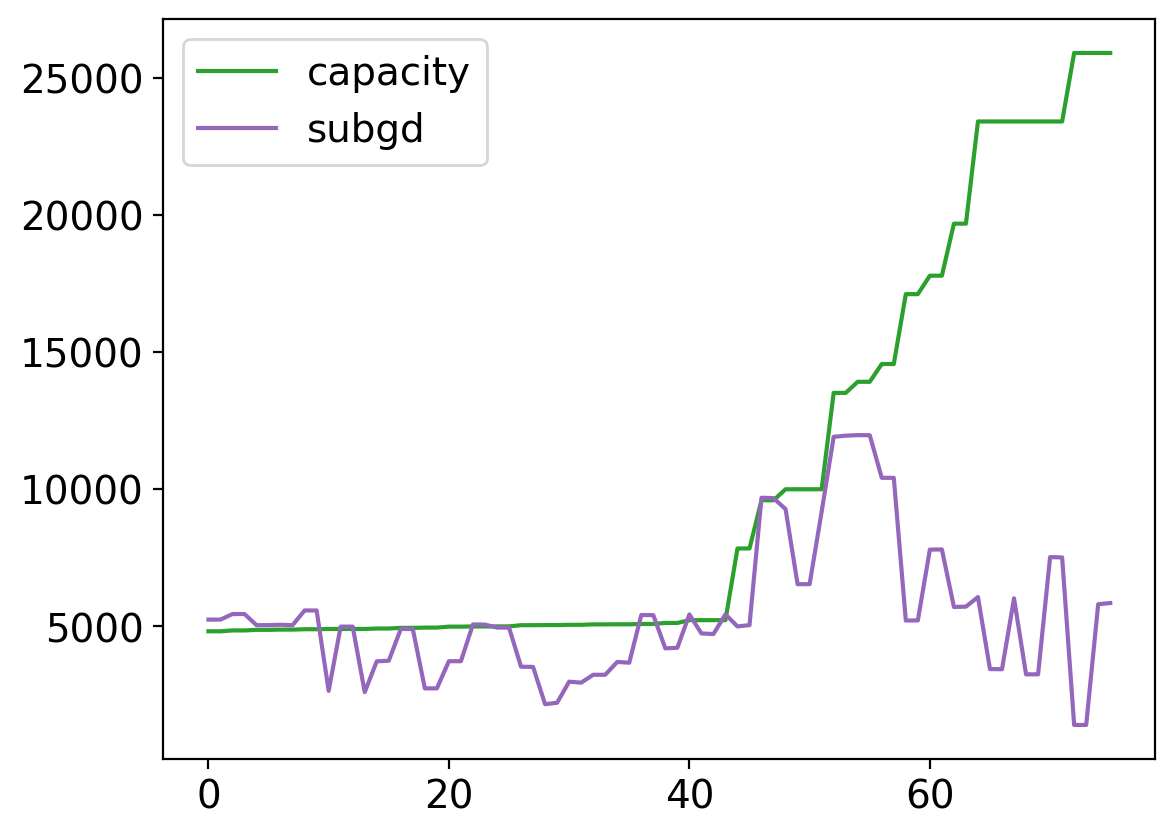

In [15]:
bws = sd_model.graph.ep.capacities.a
order = bws.argsort()

plt.plot(bws[order], label="capacity", c='C2')
# plt.plot(flows_cvx[order], label="cvxpy", c="C1")
plt.plot(flows_e_subgd[order], label="subgd", c="C4")

plt.legend()

# Twostage

In [322]:
traffic_mat = beckmann_model.correspondences.traffic_mat.copy() 
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0) 
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)

print(eps_abs, eps_cons_abs)

321.76227778320316 1.0247206298828127


In [35]:
times_ustm_2s, primal_var_ustm_2s, logs, optimal = ustm(twostage_beckmann_model, eps_abs=100, max_iter=1000, stop_by_crit=False)
dgap_ustm_2s, cons_log_ustm_2s, time_log_ustm_2s = logs
print(len(dgap_ustm_2s), "iters")

  8%|▊         | 83/1000 [00:02<00:24, 37.02it/s]

KeyboardInterrupt



  7%|▋         | 1/15 [00:55<12:51, 55.12s/it]

0 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 1
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 13%|█▎        | 2/15 [01:50<11:59, 55.31s/it]

1 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 2
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 20%|██        | 3/15 [02:45<11:02, 55.22s/it]

2 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 3
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 27%|██▋       | 4/15 [03:40<10:06, 55.17s/it]

3 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 4
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 33%|███▎      | 5/15 [04:35<09:11, 55.10s/it]

4 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 5
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 40%|████      | 6/15 [05:30<08:16, 55.13s/it]

5 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 6
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 47%|████▋     | 7/15 [06:26<07:21, 55.19s/it]

6 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 7
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 53%|█████▎    | 8/15 [07:21<06:25, 55.14s/it]

7 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 8
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 60%|██████    | 9/15 [08:16<05:31, 55.20s/it]

8 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 9
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 67%|██████▋   | 10/15 [09:11<04:35, 55.09s/it]

9 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 10
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 73%|███████▎  | 11/15 [10:06<03:40, 55.06s/it]

10 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 11
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 80%|████████  | 12/15 [11:01<02:45, 55.05s/it]

11 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 12
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 87%|████████▋ | 13/15 [11:56<01:50, 55.08s/it]

12 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 13
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
 93%|█████████▎| 14/15 [12:51<00:55, 55.05s/it]

13 10000


/home/demyan/reps/mmo_tm/src/algs.py:462: RuntimeWarning: Traffic model solver did not converge on big iter 14
  warnings.warn(f"Traffic model solver did not converge on big iter {k}", category=RuntimeWarning)
100%|██████████| 15/15 [13:47<00:00, 55.19s/it]

14 10000


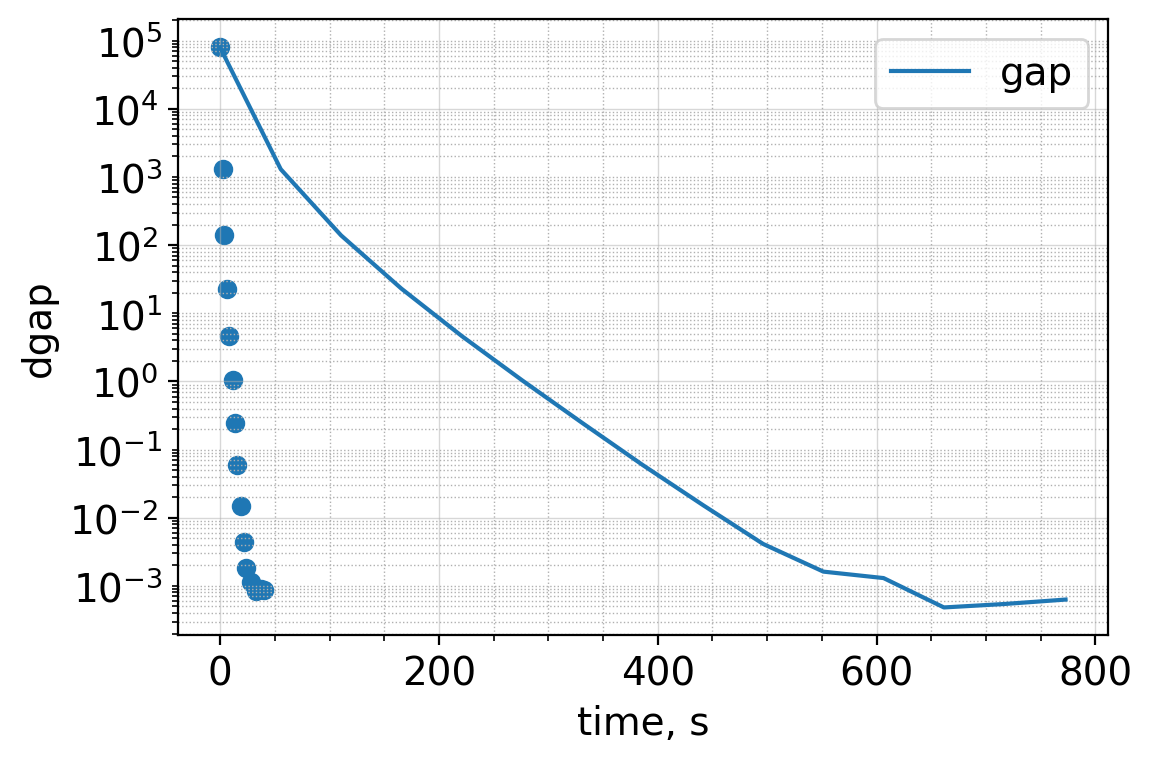

In [257]:
times_e_best, flows_e_best, d_ij_best, logs, optimal = cyclic(model=twostage_beckmann_model, 
                                                                eps_abs=eps_abs, 
                                                                traffic_assigment_eps_abs=1e-3, 
                                                                traffic_assigment_max_iter=10000, 
                                                                max_iter=15, 
                                                                stop_by_crit=False)


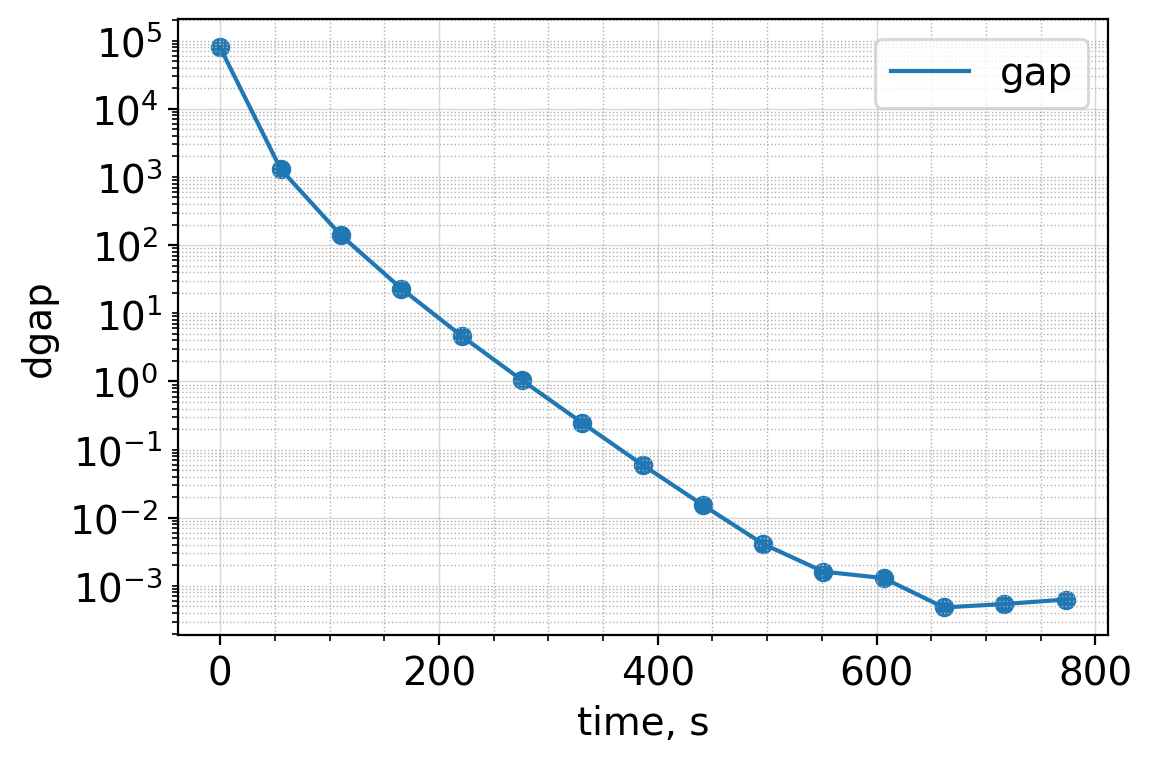

In [259]:
ax = plt.figure(figsize=(6,4)).add_subplot(1, 1, 1)
ax.plot(logs[2], logs[0], label=f"gap")
ax.scatter(logs[2], logs[0])

ax.minorticks_on()
ax.set_yscale("log")
ax.set_ylabel("dgap")
ax.set_xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 
ax.legend()
plt.show()

In [311]:
dgaps = []
times = []
dists = []
ta_epss = 10.0 ** np.arange(2, -2, -1)

for ta_eps in ta_epss:
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = cyclic(model=twostage_beckmann_model, 
                                                                    eps_abs=eps_abs, 
                                                                    traffic_assigment_eps_abs=ta_eps, 
                                                                    traffic_assigment_max_iter=10000, 
                                                                    max_iter=20, 
                                                                    stop_by_crit=False,
                                                                    solution_flows=flows_e_best,
                                                                    solution_corrs=d_ij_best,
                                                                    )
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgaps.append(dgap_cyclic)    
    times.append(time_log_cyclic)    
    dists.append((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5)
    

  5%|▌         | 1/20 [00:00<00:12,  1.53it/s]

0 150
1 74


 15%|█▌        | 3/20 [00:01<00:06,  2.82it/s]

2 60


 20%|██        | 4/20 [00:01<00:05,  3.06it/s]

3 68
4 54


 35%|███▌      | 7/20 [00:02<00:03,  3.90it/s]

5 75
6 43


 40%|████      | 8/20 [00:02<00:03,  3.92it/s]

7 58


 45%|████▌     | 9/20 [00:02<00:03,  3.50it/s]

8 79


 50%|█████     | 10/20 [00:03<00:02,  3.37it/s]

9 72


 55%|█████▌    | 11/20 [00:03<00:02,  3.58it/s]

10 52


 60%|██████    | 12/20 [00:03<00:02,  3.39it/s]

11 71


 65%|██████▌   | 13/20 [00:03<00:01,  3.61it/s]

12 57


 70%|███████   | 14/20 [00:04<00:01,  3.64it/s]

13 65


 75%|███████▌  | 15/20 [00:04<00:01,  3.79it/s]

14 59


 85%|████████▌ | 17/20 [00:04<00:00,  4.25it/s]

15 56
16 47


 90%|█████████ | 18/20 [00:04<00:00,  4.85it/s]

17 33


 95%|█████████▌| 19/20 [00:05<00:00,  4.40it/s]

18 69


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


19 59


  5%|▌         | 1/20 [00:00<00:17,  1.07it/s]

0 227


 10%|█         | 2/20 [00:01<00:11,  1.59it/s]

1 93


 15%|█▌        | 3/20 [00:01<00:08,  2.02it/s]

2 79


 20%|██        | 4/20 [00:02<00:09,  1.69it/s]

3 166


 25%|██▌       | 5/20 [00:03<00:08,  1.67it/s]

4 136


 30%|███       | 6/20 [00:03<00:08,  1.71it/s]

5 133


 35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

6 190


 40%|████      | 8/20 [00:05<00:07,  1.52it/s]

7 155


 45%|████▌     | 9/20 [00:05<00:07,  1.46it/s]

8 175


 50%|█████     | 10/20 [00:06<00:06,  1.46it/s]

9 160


 55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

10 154


 60%|██████    | 12/20 [00:07<00:05,  1.42it/s]

11 186


 65%|██████▌   | 13/20 [00:08<00:04,  1.54it/s]

12 127


 70%|███████   | 14/20 [00:09<00:03,  1.56it/s]

13 143


 75%|███████▌  | 15/20 [00:10<00:03,  1.35it/s]

14 226


 80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

15 103


 85%|████████▌ | 17/20 [00:10<00:01,  1.66it/s]

16 118


 90%|█████████ | 18/20 [00:11<00:01,  1.77it/s]

17 107


 95%|█████████▌| 19/20 [00:11<00:00,  1.77it/s]

18 133


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


19 102


  5%|▌         | 1/20 [00:02<00:53,  2.80s/it]

0 624


 10%|█         | 2/20 [00:03<00:29,  1.65s/it]

1 183


 15%|█▌        | 3/20 [00:04<00:21,  1.24s/it]

2 168


 20%|██        | 4/20 [00:05<00:17,  1.09s/it]

3 191


 25%|██▌       | 5/20 [00:06<00:14,  1.03it/s]

4 165


 30%|███       | 6/20 [00:06<00:13,  1.04it/s]

5 217


 35%|███▌      | 7/20 [00:08<00:13,  1.02s/it]

6 255


 40%|████      | 8/20 [00:09<00:15,  1.25s/it]

7 396


 45%|████▌     | 9/20 [00:10<00:12,  1.13s/it]

8 184


 50%|█████     | 10/20 [00:11<00:11,  1.17s/it]

9 274


 55%|█████▌    | 11/20 [00:13<00:10,  1.19s/it]

10 274


 60%|██████    | 12/20 [00:14<00:09,  1.22s/it]

11 297


 65%|██████▌   | 13/20 [00:15<00:07,  1.07s/it]

12 162


 70%|███████   | 14/20 [00:16<00:06,  1.13s/it]

13 278


 75%|███████▌  | 15/20 [00:18<00:06,  1.29s/it]

14 376


 80%|████████  | 16/20 [00:19<00:05,  1.25s/it]

15 259


 85%|████████▌ | 17/20 [00:20<00:03,  1.20s/it]

16 243


 90%|█████████ | 18/20 [00:21<00:02,  1.16s/it]

17 230


 95%|█████████▌| 19/20 [00:22<00:01,  1.17s/it]

18 275


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


19 247


  5%|▌         | 1/20 [00:03<01:03,  3.36s/it]

0 740


 10%|█         | 2/20 [00:04<00:32,  1.81s/it]

1 157


 15%|█▌        | 3/20 [00:04<00:23,  1.40s/it]

2 189


 20%|██        | 4/20 [00:06<00:20,  1.26s/it]

3 216


 25%|██▌       | 5/20 [00:07<00:18,  1.25s/it]

4 257


 30%|███       | 6/20 [00:09<00:20,  1.47s/it]

5 362


 35%|███▌      | 7/20 [00:11<00:22,  1.72s/it]

6 468


 40%|████      | 8/20 [00:12<00:18,  1.50s/it]

7 231


 45%|████▌     | 9/20 [00:13<00:16,  1.46s/it]

8 301


 50%|█████     | 10/20 [00:15<00:16,  1.67s/it]

9 453


 55%|█████▌    | 11/20 [00:18<00:16,  1.87s/it]

10 512


 60%|██████    | 12/20 [00:20<00:15,  1.88s/it]

11 405


 65%|██████▌   | 13/20 [00:22<00:13,  1.99s/it]

12 472


 70%|███████   | 14/20 [00:24<00:12,  2.01s/it]

13 431


 75%|███████▌  | 15/20 [00:27<00:11,  2.38s/it]

14 701


 80%|████████  | 16/20 [00:30<00:10,  2.55s/it]

15 633


 85%|████████▌ | 17/20 [00:32<00:07,  2.35s/it]

16 386


 90%|█████████ | 18/20 [00:34<00:04,  2.24s/it]

17 420


 95%|█████████▌| 19/20 [00:36<00:02,  2.07s/it]

18 370


100%|██████████| 20/20 [00:37<00:00,  1.87s/it]

19 267


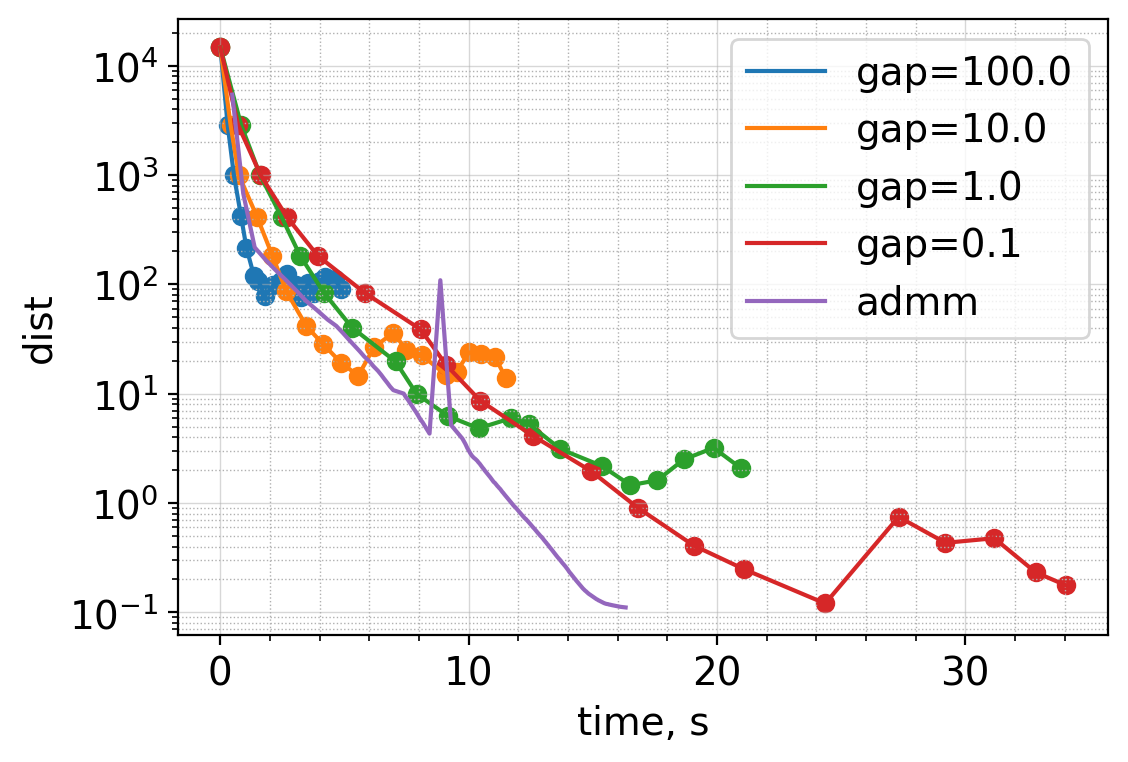

In [338]:
from matplotlib.ticker import LogLocator, LogFormatter

ax = plt.figure(figsize=(6,4)).add_subplot(1, 1, 1)
# ticks = ((10.0 ** np.arange(-1, 5, 1))[:, np.newaxis] * np.arange(1, 10, 3)).flatten()

for i in range(len(ta_epss)):
    x, y = times[i], dists[i] 
    ax.plot(x, y, label=f"gap={ta_epss[i]}")
    ax.scatter(x, y)
# plt.plot(time_log_ustm_2s, dgap_ustm_2s, c="C6", label="ustm")

ax.plot(admm_times, admm_dists, label="admm")
# ax.scatter(admm_times, admm_dists)

# Enable minor ticks
ax.minorticks_on()

# Set the y-axis to log scale
ax.set_yscale("log")
# ax.set_xscale("log")

# Set labels for axes
ax.set_ylabel("dist")
ax.set_xlabel("time, s")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
ax.yaxis.set_minor_locator(minor_locator)

# Set grid for both major and minor grid lines
ax.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

# Add legend
ax.legend()

# Display the plot
plt.show()

In [317]:
print(np.linalg.norm(flows_e_cyclic - primal_var_ustm_2s[0]), np.linalg.norm(flows_e_cyclic))
print(np.linalg.norm(d_ij_cyclic - primal_var_ustm_2s[1]), np.linalg.norm(d_ij_cyclic))

198.62573838490752 81737.54403347017
5.462979083073364 25725.202578674773


In [324]:
from src.admm_stuff import AdmmOracle

l, w = departures, arrivals
admm_oracle = AdmmOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

In [336]:
import time
from src.cvxpy_solvers import admm_argmin_traffic, admm_argmin_flows

graph = beckmann_model.nx_graph
incidence_mat = nx.incidence_matrix(graph, oriented=True).todense()

d_ij = traffic_mat.copy()  # maybe init with zeros or 1-rank approx?
# d_ij = np.ones(traffic_mat.shape)
# d_ij = l[:, np.newaxis] @ w[np.newaxis, :] / l.sum()

rho = 0.1 

y = np.zeros(traffic_mat.shape)

f_dist, d_dist, cons, dual_res = [], [], [], []
f_dual_feas, d_dual_feas = [], []
lam, mu = None, None

# TODO: reuse previous solution as starting point for subproblems, terminate by crit. 

flows_ei, y_salim = None, None
start = time.time()
admm_times = []
for k in tqdm(range(450)):
#     print("time passed:", round(time.time() - start), "s")
    
    flows_ei_ = admm_oracle.agd_argmin_flows(d_ij, y, rho, x0=flows_ei, eps_abs=5e-6, iters=1000, M0=10) 
#     if k > 0:
#         print("flows change norm", np.linalg.norm(flows_ei_ - flows_ei))
    flows_ei = flows_ei_

    d_ij_, y_salim = admm_oracle.salim_argmin_corrs(y_admm=y, flows_ei=flows_ei, eps_abs=1e-5,
                                                    rho=rho, x0=d_ij, y0=y_salim,
                                                    mu=0.01, L=1, iters=1000) 
#     print("corrs change norm", np.linalg.norm(d_ij - d_ij_))
    dual_res.append(rho * np.linalg.norm(admm_oracle.ATmul(admm_oracle.Bmul(d_ij - d_ij_))))
    d_ij = d_ij_
    
    Bd_plus_Af = admm_oracle.Amul(flows_ei) + admm_oracle.Bmul(d_ij)
    y += rho * Bd_plus_Af
    
    admm_times.append(time.time() - start)
    f_dist.append(np.linalg.norm(flows_e_best - flows_ei.sum(axis=1)))
    d_dist.append(np.linalg.norm(d_ij_best - d_ij))
    
    cons.append(np.linalg.norm(Bd_plus_Af))  # primal residual
    
#     print("\n", k)
#     print(f"flows dist={f_dist[-1]}, corrs dist={d_dist[-1]}")
#     print(f"constraint={cons[-1]}", f"optimality={dual_res[-1]}", "\n")

/tmp/ipykernel_27843/1017970501.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  incidence_mat = nx.incidence_matrix(graph, oriented=True).todense()
100%|██████████| 450/450 [00:16<00:00, 27.57it/s] 


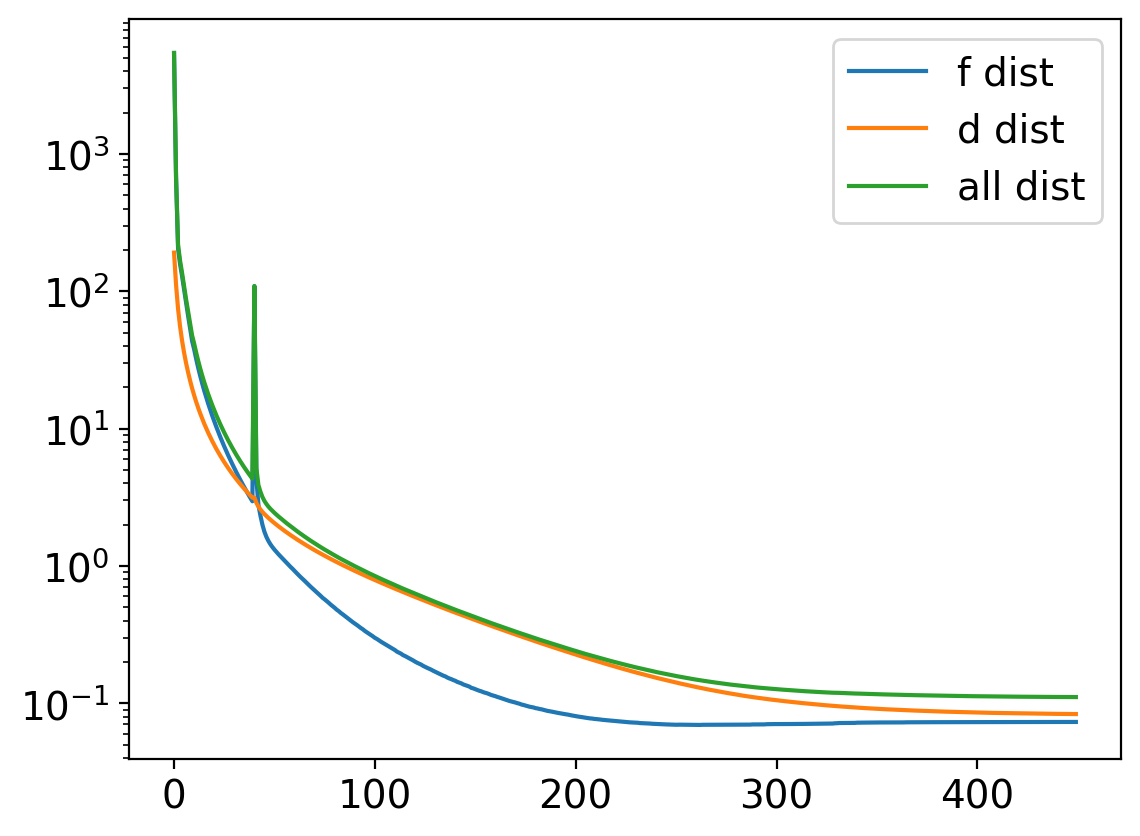

In [337]:
plt.plot(f_dist, label="f dist")
plt.plot(d_dist, label="d dist")
admm_dists = (np.array(d_dist) ** 2 + np.array(f_dist) ** 2) ** 0.5
plt.plot(admm_dists, label="all dist")
plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.show()

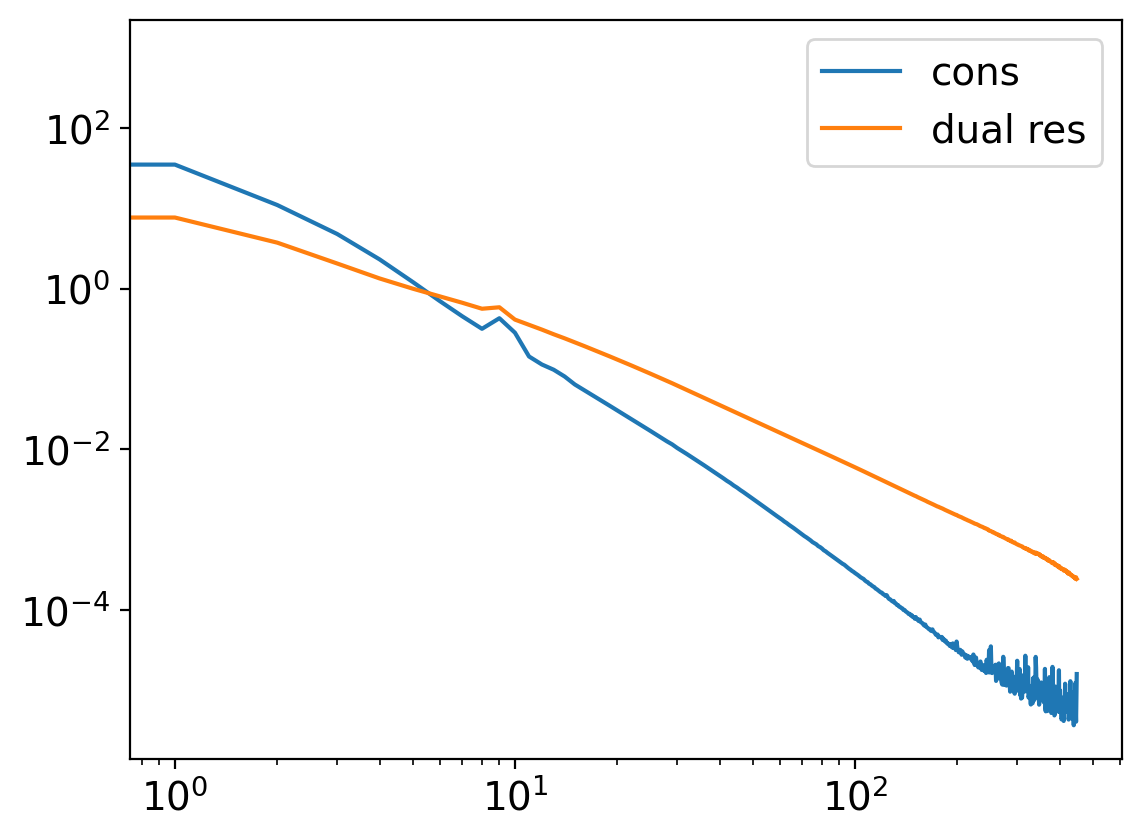

In [328]:
plt.plot(cons, label="cons")
plt.plot(dual_res, label="dual res")
plt.legend()
plt.yscale("log")
plt.xscale("log")


flows agd: 29882.807260736863 M= 5.0e+01
flows agd: 0.08258447173294199 M= 7.8e-01
flows agd: 0.01876050677762064 M= 1.6e+00
flows agd: 0.006436107020733585 M= 7.8e-01
flows agd: 0.002830855398512112 M= 7.8e-01


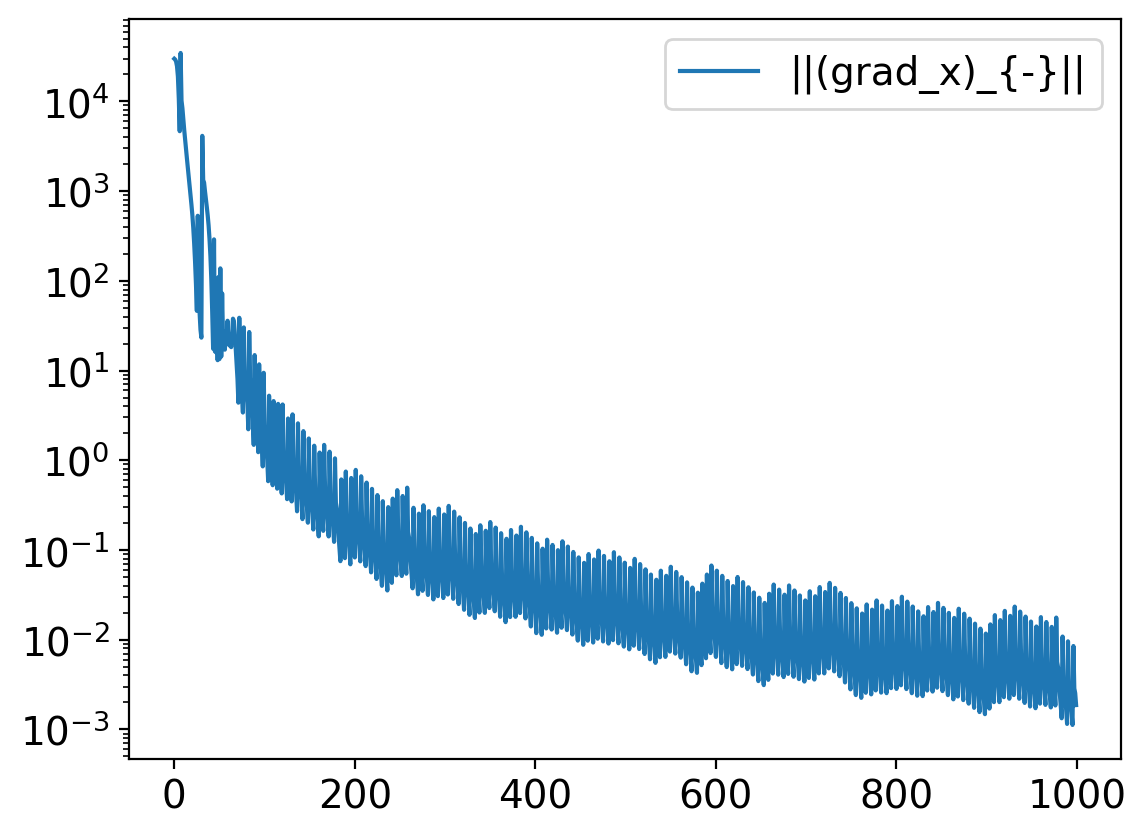

In [26]:
x = admm_oracle.agd_argmin_flows(d_ij, y, rho, iters=1000, M0=100, plot_convergence=True)

0.2
Salim cons=8.743e+05 func=8.395e+05
Salim cons=2.889e+03 func=4.600e+02
Salim cons=1.415e+01 func=1.107e+01
Salim cons=4.314e-01 func=3.423e-01
Salim cons=1.753e-02 func=1.398e-02


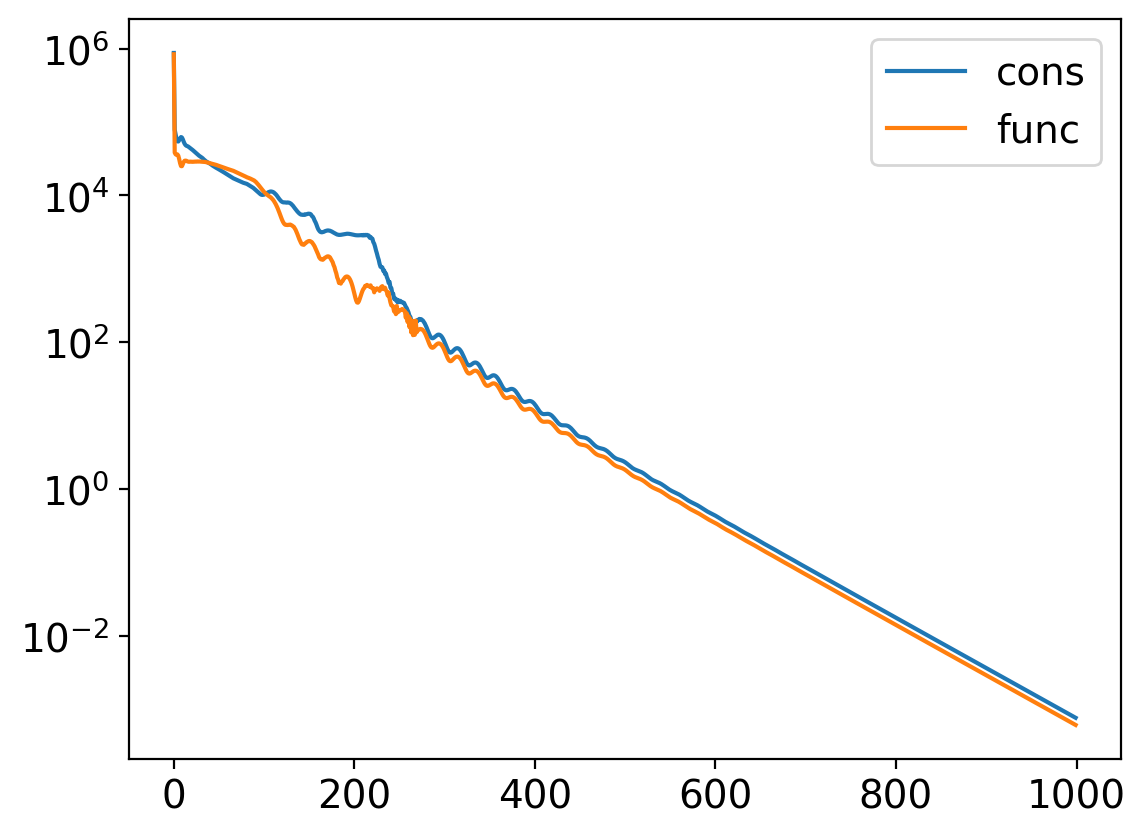

CPU times: user 271 ms, sys: 177 ms, total: 448 ms
Wall time: 260 ms


In [27]:
%%time 
print(rho)
x, y_salim = admm_oracle.salim_argmin_corrs(y_admm=y,
                                      flows_ei=flows_ei,
                                      rho=rho,
                                      mu=1e-3,
                                      L=1,
                                      iters=1000,
                                      plot_convergence=True)